# Making Our Own Hubble Diagram

In this Notebook we will create our own Hubble Diagram -- the relationship between distance and redshift. Throughout the process, we'll get to:

-practice using Python to manipulate data sets and make plots

-convert between different astronomical units (flux, magnitude, distance, etc.)

-learn what 'redshift'

-see how the expansion of the universe was discovered, and

-see how the expansion rate of the universe allows us to calculate distances to astronomical objects

First, we need to import all the modules we will use in this notebook. A 'module' is basically a prewritten piece of code that we can use to make a lot of processes much easier. 

A simple module might be something like divide_then_power, which divides the first input by the second input and then raises the result to the power of the third input (not sure why you would need something like this, but let's just go with it). 

Once you import this module, you might call it by typing "divide_then_power(4,2,3)," which would perform the operation (4/2)^3 and return 8, without you having to do all the messy work yourselves. 

Below I've written a little summary of what we will use each module for. (When we use the from ... import ..., that is because we are just importing a specific function from a larger module.)

In [15]:
from astropy.io import fits # a way to read in and manipualte a data format called fits
from astropy import constants as const # gives us constants like c (speed of light), G (gravitational constant), etc.
import matplotlib.pyplot as plt # the most common plotting module in python
from astropy import units as u # let's us attach units to our data
from scipy import stats # we'll just use it for a linear regression, to find the best fit slope of a scatterplot
from astropy.coordinates import SkyCoord # lets us go between different coordinate types easily
from astropy.coordinates import Distance, Angle # don't think we use this, not sure why I have it here, leaving it just in case
from astropy.table import Table, Column # lets us put our data into a nice Table that is easy to work with
from astropy.io import ascii # don't think we use this either
import numpy as np # basic math operations
%matplotlib inline

Now that we've got our modules, it's time to read in our data. Download the file "galaxies_subset.fits" from my GitHub page and then use the cell below to get to the directory -- probably Downloads -- that the file is in. Remember, you have to be in the right directory to import a file! pwd to see where you are and cd to change directory!

In [2]:
cd Downloads

/Users/archiekinnane/Downloads


A bit about the data you are working with: this file is a (not exactly) random sample of 100 of the hundreds of thousands of galaxies identified by SDSS -- the Sloan Digital Sky Survey. I got it by querying the SDSS dataset and saving every 1000th galaxy. To do this, we use a different programming language called SQL. If you're curious, here's the SQL code to get this dataset. 

SELECT TOP 100 objId,z,zErr,absMagR, lumDist, distMod, synthR
FROM Photoz
WHERE
 nnIsInside=1 
 and nnCount>95 
 and zErr BETWEEN 0 and 0.03 
 and (objId%1000) = 0 


Don't worry about this yet -- you'll learn how to query soon, though!

Once we're in the right directory we want to open and inspect the data from the fits file. To open a fits file, we use the operator "open." You then want to save this as whatever name you choose. So something like:

name_you_choose = fits.open("name_of_file.fits")

Go ahead and open the file below.

In [4]:
#open and name the fits file

hdu1 = fits.open("galaxies_subset.fits")



Once you've done this, let's make sure everything we want is there. "info" gives you some basic information about the file. Type "name_you_chose.info()" to see this.

Fits files usually have two sections -- the first, called PRIMARY, just has some basic information about the file, and nothing that we will really use. The second one is where the real data is. Make sure it has the right dimensions! Now let's check if all our columns are here, by typing "name_you_chose[1].columns". The [1] lets Python know you want the columns in the second fits array -- where the data is (Python starts numbering things with 0.) 

In [5]:
# look at the fits file's 'info'

hdu1.info()

# have python list the columns for us

print(hdu1[1].columns)



Filename: galaxies_subset.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (0,)            
1                BinTableHDU     22   100R x 7C    [1K, 1E, 1E, 1E, 1E, 1E, 1E]   
ColDefs(
    name = 'objId'; format = '1K'
    name = 'z'; format = '1E'
    name = 'zErr'; format = '1E'
    name = 'absMagR'; format = '1E'
    name = 'lumDist'; format = '1E'
    name = 'distMod'; format = '1E'
    name = 'synthR'; format = '1E'
)


Now let's put our data in a neat astropy Table. We'll use the Table module we imported above. You can call the table whatever you want, but it should be something that's both reflective of what's in it (galaxy data) but also short enough that it's not a pain to type out, which we will be doing a lot.

This module works like this: table_name = Table(name_you_chose_before[1].data)

(It might seems silly to have to retype a lot of these^ commands, but that's really the best way to learn how to code!)

In [6]:
# create your table here

from astropy.table import Table
Hub_gal = Table(hdu1[1].data)

Then you can just type the name of your table to see it!

In [7]:
# look at your table

Hub_gal

objId,z,zErr,absMagR,lumDist,distMod,synthR
int64,float32,float32,float32,float32,float32,float32
1237645941296923000,0.250062,0.024561,-21.5395,882.371,39.7283,18.5495
1237645941298365000,0.24582,0.026461,-19.9996,865.39,39.6861,20.0239
1237645941834908000,0.087063,0.024864,-19.4898,278.08,37.2209,17.7713
1237645942907732000,0.261936,0.024943,-20.8707,930.236,39.843,19.3054
1237645942908716000,0.388622,0.023132,-21.0093,1469.65,40.8361,20.5011
1237645943435035000,0.200231,0.024691,-18.9625,686.933,39.1846,20.4472
1237645943978984000,0.39692,0.029637,-19.8543,1506.71,40.8901,21.7909
1237646585556370000,0.066177,0.025145,-16.7825,208.332,36.5938,19.7767
1237646585559647000,0.074538,0.029302,-15.5224,236.029,36.8648,21.431


It's usually a good idea to close your fits file once you've read the data into a table. Do this using name_you_chose.close()

In [8]:
hdu1.close()

Now we want to add some columns to our Table. But first, we need to understand what columns we already have!

objId: just a number corresponding to the galaxy for record keeping

z: redshift

zErr: the error in the redshift

lumDist and distMod: these are two different types of distance measurements. We don't *technically* need these but we'll use them a little later on to cheat and make our graph a little bit cleaner.

synthR: magnitude of the galaxy in the R band -- this just means how bright the galaxy is in the general wavelength range that corresponds to red light

Now: what columns do we want to add? Actually, let's take a brief pause to revisit what we are trying to do here.

Basically, we are making a Hubble Diagram -- a graph of distance versus redshift. We already have redshift, so we're good there. But we don't have distance. (Distances are actually a really hard thing to find in astronomy!) 

What we do have is magnitude -- how bright the galaxy is. From this we can get relative distance -- galaxies farther away should be dimmer, right? Kinda. Write below what assumptions this logic is built on:

Assumptions:
    


### When you get here take a break and come see me and we'll go over the assumptions, and talk a little more about redshift and another distance method that relies on what are called "standard candles"!

To convert the magnitudes we have --synthR -- to distances, we have to first stop over at flux (relative flux, that is), using the formula:

Flux = 2.5^(-Magnitude)

See if you can figure out how to do an operation like this using numpy! 



In [10]:
# practice a power operation using numpy
np.power(2.5, -1)


0.40000000000000002

Once you figure this out, we need to 
1) make a column where we apply this operation to every row of 'synthR' -- our magnitudes
2) name this column, and
3) add this column to our table

We can do this all with one line, using an attribute of Table called "add_column"

table_name.add_column(Column(**your operation using numpy and table_name['synthR'] goes here**, name = 'flux']

Use the cell below to do this.

In [11]:
# add flux column

Hub_gal.add_column(Column(np.power(2.5, -1*Hub_gal['synthR']),name='flux'))

Now we do the exact same thing, but now we're going from relative flux to relative distance. This uses the formula"

Relative distance = 1 / sqrt(Flux)

Add a column to our table for relative distance, and name it rel_dist.

In [12]:
# work out the numpy code, then add relative distance column

Hub_gal.add_column(Column(1 / np.power(Hub_gal['flux'], 0.5), name = 'rel_dist'))

Use the cell below to look at your table again. Are the new columns there?

In [13]:
# print table

Hub_gal

objId,z,zErr,absMagR,lumDist,distMod,synthR,flux,rel_dist
int64,float32,float32,float32,float32,float32,float32,float32,float32
1237645941296923000,0.250062,0.024561,-21.5395,882.371,39.7283,18.5495,4.15348e-08,4906.75
1237645941298365000,0.24582,0.026461,-19.9996,865.39,39.6861,20.0239,1.0757e-08,9641.74
1237645941834908000,0.087063,0.024864,-19.4898,278.08,37.2209,17.7713,8.47401e-08,3435.23
1237645942907732000,0.261936,0.024943,-20.8707,930.236,39.843,19.3054,2.07782e-08,6937.38
1237645942908716000,0.388622,0.023132,-21.0093,1469.65,40.8361,20.5011,6.94691e-09,11997.9
1237645943435035000,0.200231,0.024691,-18.9625,686.933,39.1846,20.4472,7.29862e-09,11705.2
1237645943978984000,0.39692,0.029637,-19.8543,1506.71,40.8901,21.7909,2.13073e-09,21663.8
1237646585556370000,0.066177,0.025145,-16.7825,208.332,36.5938,19.7767,1.34915e-08,8609.34
1237646585559647000,0.074538,0.029302,-15.5224,236.029,36.8648,21.431,2.96311e-09,18370.7


Now we're going to plot our relative distances versus redshift using matplotlib.pyplot (which we've imported as just plt so we don't have to type that whole thing out every time). Put relative distance on the x-axis, and redshift on the y-axis. Label your axes! 

Here's a pyplot reference: https://matplotlib.org/users/pyplot_tutorial.html

And if you get stuck just let me know!

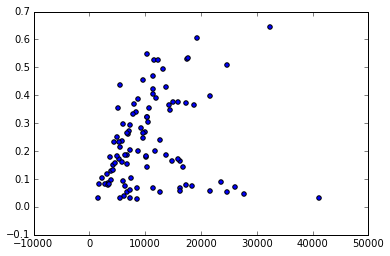

In [16]:
# plot redshift versus distance

plt.scatter(Hub_gal['rel_dist'], Hub_gal['z'])



What's the general trend? Remember what redshift means -- what does this tell us about the relationship between distance and recession speed?

Answer: 

With better data this relationship would be more linear. What do you think is introducing such large errors?

Answer:



Now we're going to cheat a bit. Since our y-axis is relative distance, our slope has meaningless units. But we also have "actual" distances to these galaxies in our table (by the end of the Notebook you'll understand why it would have been redudant to use these distances from the start). What we can do is "normalize" our relative distances with our lumDist values. 

There's no reason to prefer one ratio over any of the others, so let's just use the first! Remember, you can call a specific row of our table like this:

1st row of lumDist column: your_table_name['lumDist'][1]

1st row of rel_dist column: your_table_name['rel_dist'][1]

If we multiply every entry in our relative distance column by this "conversion factor", then we should end up with real distances with physically meaningful distances.

Add a column to our table where we do this^. Name it 'dist'. This is a little confusing so come see me if you're having problems!

In [17]:
# add distance column. print your table to make sure it's there

Hub_gal.add_column(Column(Hub_gal['rel_dist']*(Hub_gal['lumDist'][1]/Hub_gal['rel_dist'][1]), name = 'dist'))

Since we're already cheating, we might as well go all the way. Next, we're going to use a for loop to get rid of all of our galaxies that have calculated distances too far from their 'actual' values. What types of galaxies do we expect to be deleted when we do this?

Answer:



Let's say that we'll get rid of galaxies with distances less than half or more than twice their lumDist value. Use a for loop to delete rows that have distances outside these ranges.

Here's a few things you might need for this. 

You want the range of your for loop to be the entire set. len(name_of_set) will give you the length of a data set -- a good thing to use for for loops so that your code will still work if you change the length of the data you're working with.

name_of_you_table.remove_row(i) will delete the ith row

So iterate through our table, removing a row if it has a dist less than 0.5 * lumDist or greater than 2 * lumDist!

In [18]:
# for loop -- you'll probably run into an error here, come see me for a workaround!

badrow = []

for i in range(0, len(Hub_gal['lumDist'])):
    if Hub_gal['lumDist'][i] / Hub_gal['dist'][i] > 2 or Hub_gal['lumDist'][i] / Hub_gal['dist'][i] < 0.5:
        badrow.append(i)
        
badrow_rev = []

for i in reversed(badrow):
    badrow_rev.append(i)

for i in range(0, len(badrow)):
    Hub_gal.remove_row(badrow_rev[i])

How many rows did we delete? 

Answer:



In [19]:
# find new length of table

len(Hub_gal)

68

Two more things: 

First, plot the new data! Does it look better?

Next, let's find the slope of a line of best fit for this graph! We're going to use the stats package. The code should look like this:

stats.linregress(x,y)

Multiply the redshift value by 300,000 to convert it from redshift (unitless) to recession speed. (You can just do 300,000 * your_table['z'] in the plt.plot argument.)

Where does the 300,000 come from? What units will this make our recession speed?

Answer:



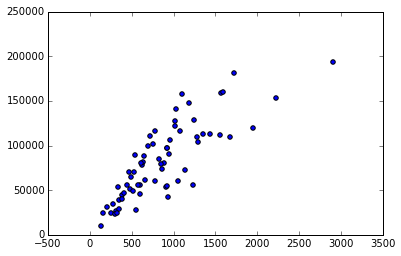

In [22]:
# make a new plot

plt.scatter(Hub_gal['dist'],300000*Hub_gal['z'])


In [25]:
# find the slope of the line of best fit

stats.linregress(Hub_gal['dist'], 300000*Hub_gal['z'])

(67.735503738436051,
 23824.195261347886,
 0.82503530045910944,
 5.1335656705842313e-18,
 5.7106128527912565)

The first output is the slope! What value did you get? The distance units we converted to are Megaparsecs. What units does this make the slope?

Answer: 68 km/s/Mpc

